In [ ]:
%pip install git+https://github.com/upaq/covid19-models.git

In [158]:
import datetime
import matplotlib.pyplot as plt
import autograd.numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from autograd import grad, hessian
from autograd import elementwise_grad as egrad
from covid_models import CovidData
from datetime import datetime, timedelta
from google.colab import files

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [159]:
# Get the training data
cd = CovidData(remove_china_correction=True)

In [185]:
def frechet(params, x, features):  
  alpha = np.exp(params[0])           # shape > 0
  s = np.exp(params[1])               # scale > 0
  m = - np.exp(params[2])             # location < x of the minimum
  beta = params[3]                    # log normalization
  
  npis = 0                            # npi_scaling(params, x, features)
  d = (x - m) / s
  return np.exp(beta - (1 + alpha) * np.log(d) - np.power(d, - alpha) - npis)

def npi_scaling(params, x, features):
  """The NPI scaling is any function that's factorized out (here)."""
  bias = params[4]                    # bias
  w = params[5:]                      # weights    
  inner = np.dot(features, w) + bias
  return inner - np.exp(inner) * x

def frechet_mixture(params, x, features):
  f = 0 * np.zeros(len(x))
  for param in params:
    f = f + frechet(param, x, features)
  return f

def log_prior(params):
  log_alpha = params[0]
  log_s = params[1]  
  w = params[4:]
  return - 0.5 * (log_alpha * log_alpha +
                  log_s * log_s +
                  0.1 * np.sum(w * w))
  
# Set the loss here. Poisson or Gaussian.
def f_loss(f, y, precision, tolerance, y_variance=False):
  return f_loss_poisson(f, y)
# ------------------------------------------------------------------------------

def f_loss_gaussian(f, y, precision=1.0, tolerance=0.02, y_variance=False):
  d = (y - f) * (y - f)
  if y_variance:
    std_dev = frechet_std_dev(y, precision, tolerance)           
  else:
    std_dev = frechet_std_dev(f, precision, tolerance)    
  v = std_dev * std_dev  
  return 0.5 * np.sum(d / v + np.log(v))

def f_loss_poisson(f, y):
  return - np.sum(y * np.log(f) - f)

def frechet_loss(params, x, features, y, precision=1.0, tolerance=0.02):
  f = frechet(params, x, features)
  return f_loss(f, y, precision, tolerance) - log_prior(params)

def frechet_loss_y(params, x, features, y, precision=1.0, tolerance=0.02):
  f = frechet(params, x, features)
  return f_loss(f, y, precision, tolerance, y_variance=True) - log_prior(params)

def frechet_mixture_loss(params, x, features, y, precision=1.0, tolerance=0.02):
  f = frechet_mixture(params, x, features)
  lp = np.sum([log_prior(param) for param in params])
  return f_loss(f, y, precision, tolerance) - lp

def frechet_std_dev(f, precision=1.0, tolerance=0.02):
  additional_std_dev = tolerance * f + 1.0
  return additional_std_dev / np.sqrt(precision)

grad_frechet_loss = grad(frechet_loss)
grad_frechet_loss_y = grad(frechet_loss_y)
hessian_frechet_loss = hessian(frechet_loss)

grad_frechet_mixture_loss = grad(frechet_mixture_loss)

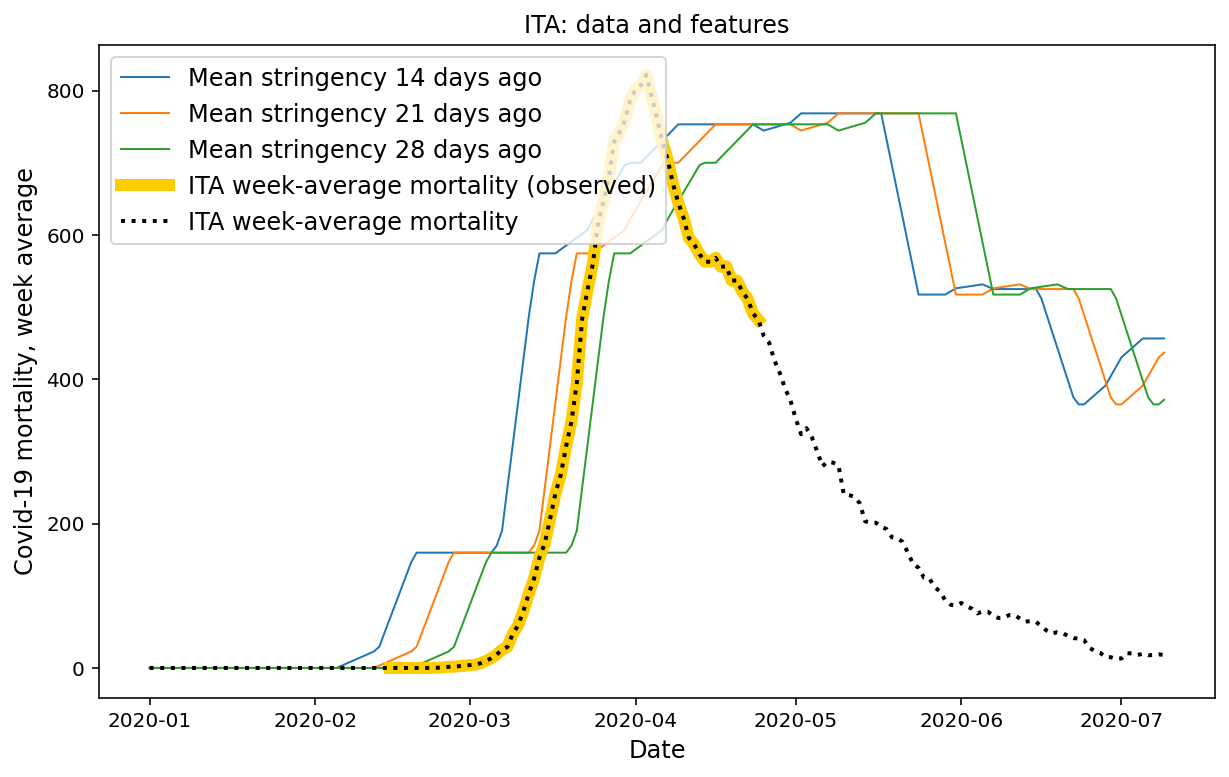

In [186]:
#@title Data
ISO = 'ITA'
MAX_DATE = datetime(2020, 4, 24)
DAYS_BACK = [14, 21, 28]

x_all, y_all, features_all = cd.create_stringency_vectors(
    ISO,
    days_back_list=DAYS_BACK)
x, y, features = cd.create_stringency_vectors(
    ISO,
    days_back_list=DAYS_BACK,
    max_date=MAX_DATE)

idx = np.where(y > 0)
idx = idx[0][0]
if ISO == 'FRA':
  idx = idx + 12
shift = idx - 1
y_ = y[shift:]
features_ = features[shift:,:]
x_ = np.arange(len(y_))

max_y = np.max(y_all)

# ---------- Plotting ----------
min_date = datetime(2020, 2, 15)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lw = 1

for i, days_back in enumerate(DAYS_BACK):
  feats = features_all[:, i] * max_y 
  ax.plot(x_all, feats, '-', lw=1, label='Mean stringency ' + str(days_back) + ' days ago')

ax.plot(x[x >= min_date], y[-sum(x >= min_date):],
        color=(255 / 255.0, 204 / 255.0, 0 / 255.0),        
        lw=6, alpha=1.0, label=ISO + ' week-average mortality (observed)')
ax.plot(x_all, y_all,
      ':k', lw=2, label=ISO + ' week-average mortality')

ax.legend(loc='upper left', ncol=1, fontsize=12)
ax.set_title(ISO + ': data and features', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Covid-19 mortality, week average', fontsize=12)

plt.show()

In [187]:
#@title Fitting and sampling a single component

# ---------- Frechet distribution ----------
# Hyperparameters
precision = 1.0
tolerance = 0.02

# Stochastic gradient descent and Hamiltonian MCMC settings
eps_scalar = 2.0
eps_scalar /= len(y)

# ----------- Gradient descent with momentum -----------
epsilon = 1e-5 * eps_scalar

frechet_params = np.array([np.log(5), np.log(100), np.log(45), np.log(100)] +
                          [0] + 
                          [0 for _ in DAYS_BACK])

g = grad_frechet_loss_y(frechet_params, x_, features_, y_, precision)
v = 0 * g
for i in range(2000):  
  g = grad_frechet_loss_y(frechet_params, x_, features_, y_, precision) 
  v = 0.9 * v - epsilon * g
  frechet_params += v

g = grad_frechet_loss(frechet_params, x_, features_, y_, precision)
v = 0 * g
for i in range(2000):  
  g = grad_frechet_loss(frechet_params, x_, features_, y_, precision) 
  v = 0.9 * v - epsilon * g
  frechet_params += v

l = frechet_loss(frechet_params, x_, features_, y_, precision)
print('Frechet after optimization, loss  =', l)
print('Frechet after optimization, g     =', g)
print('Frechet after optimization, theta =', frechet_params)

# ----------- Newton's method (if needed) -----------
epsilon = 1e-2 * eps_scalar
i_max = 0
for i in range(0):
  g = grad_frechet_loss(frechet_params, x_, features_, y_, precision)
  h = hessian_frechet_loss(frechet_params, x_, features_, y_, precision)
  hinv = np.linalg.inv(h)  
  m = np.matmul(hinv, g)  
  frechet_params -= epsilon * m

if i_max > 0:
  l = frechet_loss(frechet_params, x_, features_, y_, precision)
  print('Frechet after Newton, loss        =', l)
  print('Frechet after Newton, g           =', g)
  print('Frechet after Newton, theta       =', frechet_params)
  print('Frechet after Newton, exp(theta)  =', np.exp(frechet_params))
  # print('Frechet after Newton, H^{-1}      =', hinv)

frechet_params_max = frechet_params.copy()

# ----------- Hamiltonian Monte Carlo for one component -----------
i_max = 5000
epsilon = 2 * 1e-2 * eps_scalar
param_list = []
acceptances = 0

l = frechet_loss(frechet_params, x_, features_, y_, precision)
g = grad_frechet_loss(frechet_params, x_, features_, y_, precision)
for i in range(i_max):
  if i % 500 == 0:
    print('Done', i, 'samples at', datetime.now())
  if i > 100 and i % 100 == 0:
    param_list.append(frechet_params)  
  p = np.random.randn(5 + len(DAYS_BACK))
  H = 0.5 * np.dot(p, p) + l
  params_new = frechet_params
  v = 0 * params_new
  g_new = g
  for _ in range(20):    
    p = p - 0.5 * epsilon * g_new
    params_new = params_new + epsilon * p
    g_new = grad_frechet_loss(params_new, x_, features_, y_, precision)
    p = p - 0.5 * epsilon * g_new
  l_new = frechet_loss(params_new, x_, features_, y_, precision)  
  H_new = 0.5 * np.dot(p, p) + l_new
  dH = H_new - H

  if dH < 0:
    accept = True
  elif np.random.rand() < np.exp(- dH):
    accept = True
  else:
    accept = False
  if accept:  
    g = g_new
    frechet_params = params_new
    l = l_new
    acceptances += 1

print('Acceptance ratio:', acceptances / i_max)

Frechet after optimization, loss  = -128731.52461516393
Frechet after optimization, g     = [-22.82428724 -16.11044164 -33.07131562  -1.92711077   0.
   0.           0.           0.        ]
Frechet after optimization, theta = [1.56237672 4.54419015 3.88847623 7.55792618 0.         0.
 0.         0.        ]
Done 0 samples at 2020-07-09 23:49:12.146871
Done 500 samples at 2020-07-09 23:49:24.586868
Done 1000 samples at 2020-07-09 23:49:37.044978
Done 1500 samples at 2020-07-09 23:49:49.495380
Done 2000 samples at 2020-07-09 23:50:01.950689
Done 2500 samples at 2020-07-09 23:50:14.337178
Done 3000 samples at 2020-07-09 23:50:26.793404
Done 3500 samples at 2020-07-09 23:50:39.197094
Done 4000 samples at 2020-07-09 23:50:51.598912
Done 4500 samples at 2020-07-09 23:51:04.003352
Acceptance ratio: 0.9786


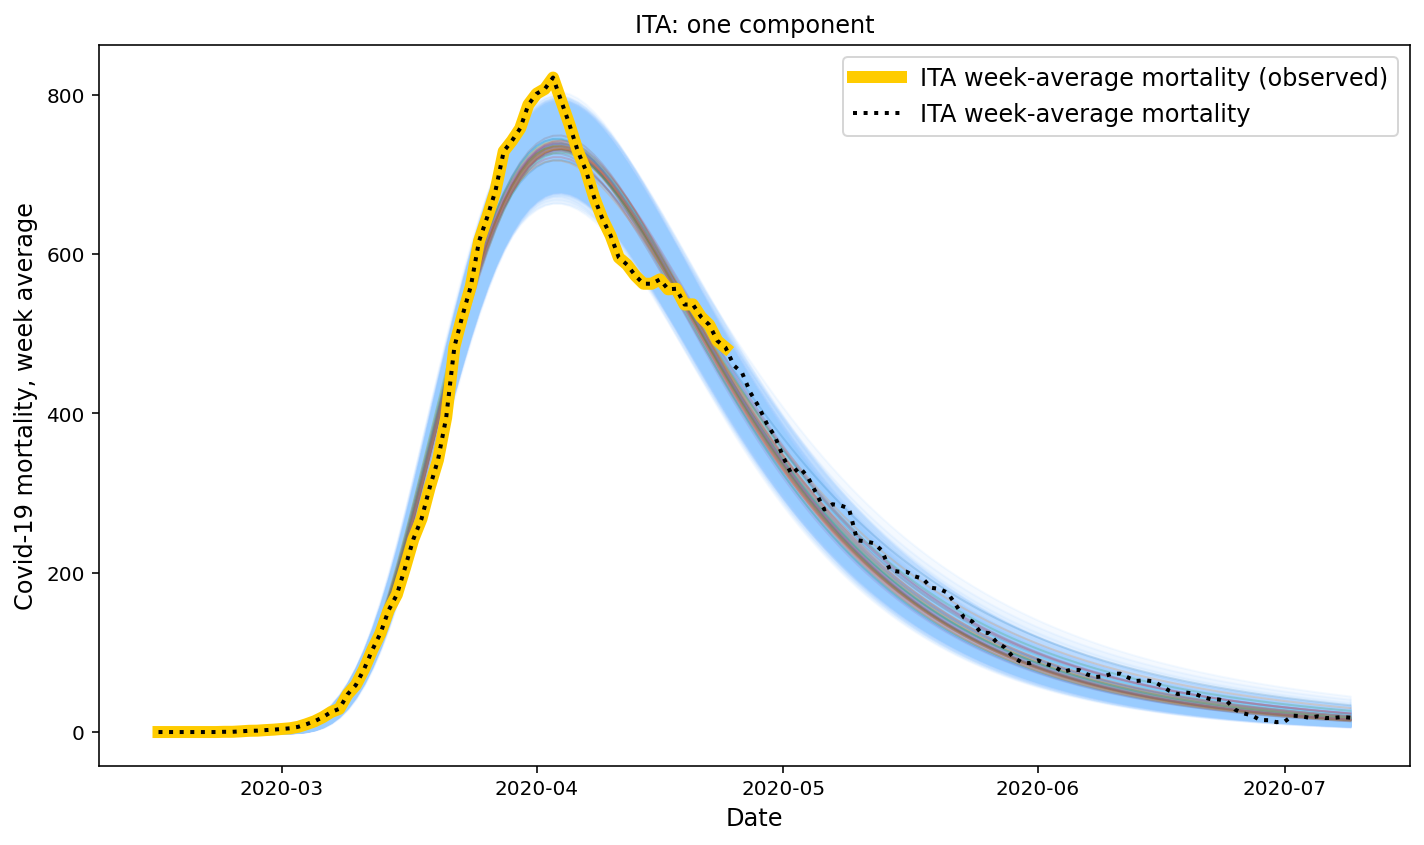

In [194]:
#@title Plotting (a single component)
save_figure = False

# ---------- Plotting ----------
min_date = datetime(2020, 2, 15)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lw = 1

y_all_ = y_all[shift:]
x_all_ = np.arange(len(y_all_))
features_all_ = features_all[shift:,:]

x_shortened = x_all[x_all >= min_date]

for params in param_list:
  yhat = frechet(params, x_all_, features_all_)
  yhat = np.concatenate([np.zeros(shift), yhat])    

  std_dev = np.sqrt(yhat)    # For Poisson
            # frechet_std_dev(yhat, precision, tolerance)
  yhat_min = yhat - 2 * std_dev
  yhat_plus = yhat + 2 * std_dev
  ax.fill_between(x_shortened, yhat_min[-len(x_shortened):],
                  yhat_plus[-len(x_shortened):], alpha=0.1,
                  color=(153 / 255.0, 204 / 255.0, 255 / 255.0))

yhat_total = np.zeros(len(x_all))
for params in param_list:  
  yhat = frechet(params, x_all_, features_all_)
  yhat = np.concatenate([np.zeros(shift), yhat])  
  yhat_total += yhat
  ax.plot(x_shortened, yhat[-len(x_shortened):], '-', alpha=0.2, lw=1)
  
yhat = frechet(frechet_params_max, x_all_, features_all_)
yhat = np.concatenate([np.zeros(shift), yhat])
# ax.plot(x_shortened, yhat[-len(x_shortened):], '-', lw=2, label='Frechet (max likelihood)')

ax.plot(x[x >= min_date], y[-sum(x >= min_date):],
        color=(255 / 255.0, 204 / 255.0, 0 / 255.0),        
        lw=6, alpha=1.0, label=ISO + ' week-average mortality (observed)')
ax.plot(x_shortened,
        y_all[-len(x_shortened):],
        ':k', lw=2, label=ISO + ' week-average mortality')

ax.legend(loc='upper right', ncol=1, fontsize=12)
ax.set_title(ISO + ': one component', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Covid-19 mortality, week average', fontsize=12)

plt.tight_layout()
if save_figure:
  plt.savefig(ISO + '-one.pdf')
  files.download(ISO + '-one.pdf') 
else:
  plt.show()

yhat = yhat_total / len(param_list)

In [189]:
#@title Predictions (a single component)
last_day = len(x)
y_7 = int(y_all[last_day - 1 + 7] * 7)
yhat_7 = int(yhat[last_day - 1 + 7] * 7)
y_14 = y_7 + int(y_all[last_day - 1 + 14] * 7)
yhat_14 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14]) * 7
y_21 = y_14 + int(y_all[last_day - 1 + 21] * 7)
yhat_21 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14] +
              yhat[last_day - 1 + 21]) * 7
y_28 = y_21 + int(y_all[last_day - 1 + 28] * 7)
yhat_28 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14] +
              yhat[last_day - 1 + 21] + yhat[last_day - 1 + 21]) * 7

print('ISO & $T$ & truth & pred & $\Delta$ & \\% \\\\ \\hline')
print(ISO,  '& 7 &', y_7, '&', yhat_7, '&', y_7 - yhat_7, '&',
      '{0:.1f}\\%'.format(yhat_7 / y_7 * 100 - 100), '\\\\')
print(' & 14 &', y_14, '&', yhat_14, '&', y_14 - yhat_14, '&',
      '{0:.1f}\\%'.format(yhat_14 / y_14 * 100 - 100), '\\\\')
print(' & 21 &', y_21, '&', yhat_21, '&', y_21 - yhat_21, '&',
      '{0:.1f}\\%'.format(yhat_21 / y_21 * 100 - 100), '\\\\')
print(' & 28 &', y_28, '&', yhat_28, '&', y_28 - yhat_28, '&',
      '{0:.1f}\\%'.format(yhat_28 / y_28 * 100 - 100), '\\\\')

ISO & $T$ & truth & pred & $\Delta$ & \% \\ \hline
ITA & 7 & 2418 & 2378 & 40 & -1.7\% \\
 & 14 & 4409 & 4130 & 279 & -6.3\% \\
 & 21 & 5819 & 5425 & 394 & -6.8\% \\
 & 28 & 6937 & 6713 & 224 & -3.2\% \\


In [190]:
#@title Fitting and sampling two components
# ----------- Optimizing it as a mixture -----------
epsilon = 1e-5 * eps_scalar

p1 = frechet_params_max.copy()
p1[0] = p1[0] + 0.2
p1[1] = p1[1] - 0.2
p1[2] = np.log(np.exp(p1[2]) - 10)
p1[3] = p1[3] - np.log(2)

p2 = frechet_params_max.copy()
p2[0] = p2[0] - 0.2
p2[1] = p2[1] - 0.1
p2[2] = np.log(np.exp(p1[2]) + 10)
p2[3] = p2[3] - np.log(2)
   
mixture_params = [p1, p2]
g = grad_frechet_mixture_loss(mixture_params, x_, features_, y_, precision)
v = [0 * gr for gr in g]
for i in range(5000):
  g = grad_frechet_mixture_loss(mixture_params, x_, features_, y_, precision)
  v = [0.9 * m - epsilon * gr for m, gr in zip(v, g)]
  mixture_params = [p + m for p, m in zip(mixture_params, v)]

l = frechet_mixture_loss(mixture_params, x_, features_, y_, precision)
print('Frechet after optimization, loss  =', l)
print('Frechet after optimization, g     =', g)
print('Frechet after optimization, theta =', frechet_params)

mixture_params_max = mixture_params.copy()

# ----------- Hamiltonian Monte Carlo for mixture -----------
epsilon = 2 * 1e-2 * eps_scalar
acceptances = 0
i_max = 5000

g = grad_frechet_mixture_loss(mixture_params, x_, features_, y_, precision)
l = frechet_mixture_loss(mixture_params, x_, features_, y_, precision)
mixture_param_list = []
for i in range(i_max):
  if i % 500 == 0:
    print('Done', i, 'samples at', datetime.now())
  if i > 100 and i % 100 == 0:
    mixture_param_list.append(mixture_params)  
  p_list = [np.random.randn(5 + len(DAYS_BACK)) for _ in mixture_params]
  H = np.sum([0.5 * np.dot(p, p) for p in p_list] ) + l

  params_new = mixture_params
  v = [0 * prms for prms in params_new]
  g_new = g
  for _ in range(20):    
    p_list = [p - 0.5 * epsilon * gn for p, gn in zip (p_list, g_new)]
    params_new = [prms + epsilon * p for prms, p in zip(params_new, p_list)]
    g_new = grad_frechet_mixture_loss(params_new, x_, features_, y_, precision)
    p_list = [p - 0.5 * epsilon * gn for p, gn in zip (p_list, g_new)]
  l_new = frechet_mixture_loss(params_new, x_, features_, y_, precision)  
  H_new = np.sum([0.5 * np.dot(p, p) for p in p_list] ) + l_new
  dH = H_new - H

  if dH < 0:
    accept = True
  elif np.random.rand() < np.exp(- dH):
    accept = True
  else:
    accept = False
  if accept:    
    g = g_new
    mixture_params = params_new
    l = l_new
    acceptances += 1

print('Acceptance ratio:', acceptances / i_max)

Frechet after optimization, loss  = -128820.23876972751
Frechet after optimization, g     = [array([-9.80100877,  3.47980393,  4.64087789,  9.57684418,  0.        ,
        0.        ,  0.        ,  0.        ]), array([  2.08853827,   2.26859111,   5.1851468 , -11.86427552,
         0.        ,   0.        ,   0.        ,   0.        ])]
Frechet after optimization, theta = [ 2.39202514  5.22805134  4.96400844  7.59885232  0.48878246 -0.52927746
 -0.86619974  0.56307721]
Done 0 samples at 2020-07-09 23:51:30.194380
Done 500 samples at 2020-07-09 23:51:56.947330
Done 1000 samples at 2020-07-09 23:52:23.200695
Done 1500 samples at 2020-07-09 23:52:49.662673
Done 2000 samples at 2020-07-09 23:53:16.085328
Done 2500 samples at 2020-07-09 23:53:42.459657
Done 3000 samples at 2020-07-09 23:54:08.855697
Done 3500 samples at 2020-07-09 23:54:35.438440
Done 4000 samples at 2020-07-09 23:55:01.785551
Done 4500 samples at 2020-07-09 23:55:28.254075
Acceptance ratio: 0.996


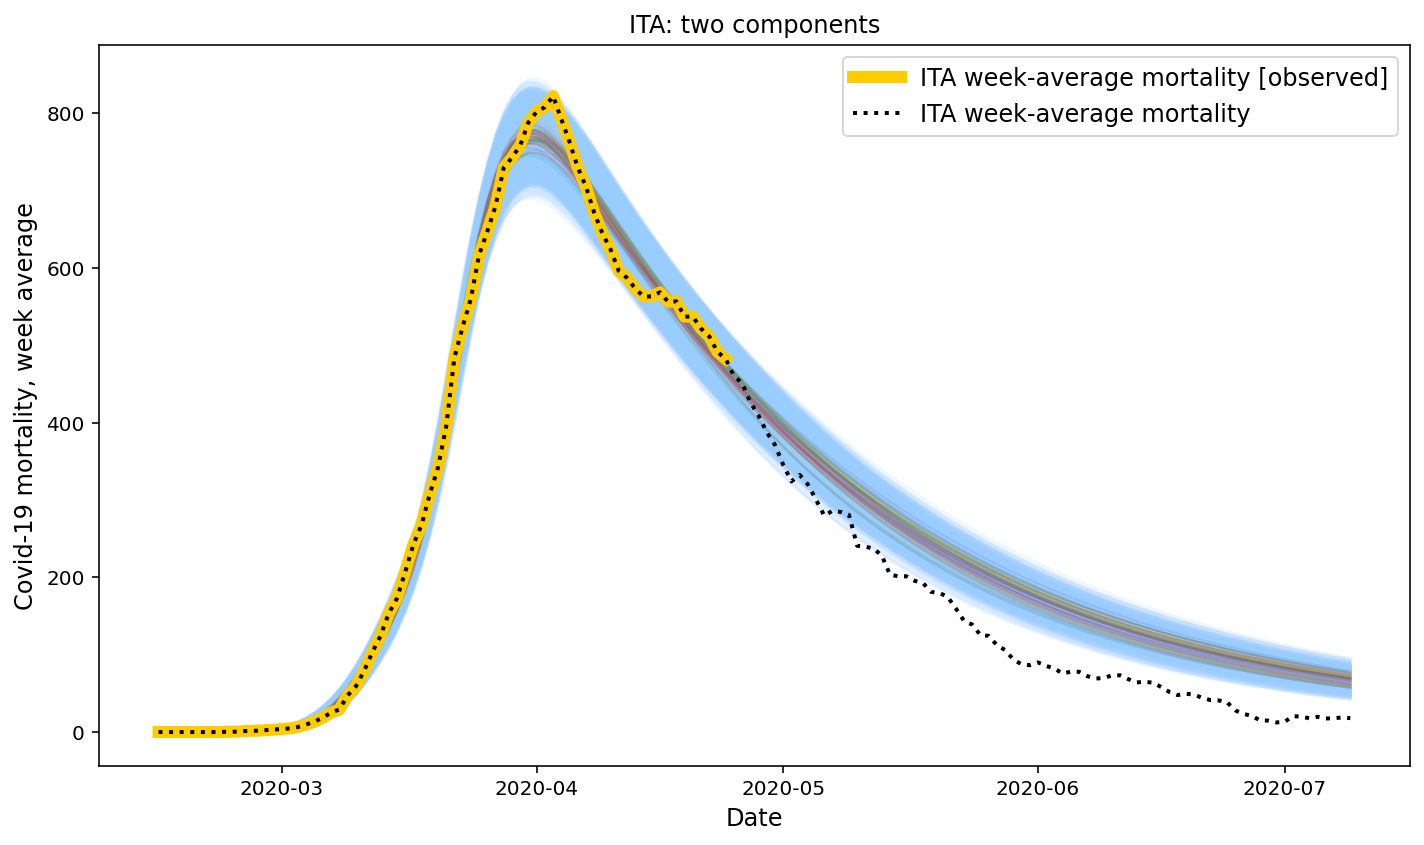

In [195]:
#@title Plotting (two components)
save_figure = False

# ---------- Plotting ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lw = 1

y_all_ = y_all[shift:]
x_all_ = np.arange(len(y_all_))
features_all_ = features_all[shift:,:]

x_shortened = x_all[x_all >= min_date]

for params in mixture_param_list:
  yhat = frechet_mixture(params, x_all_, features_all_)
  yhat = np.concatenate([np.zeros(shift), yhat])    

  std_dev = np.sqrt(yhat)    # For Poisson
            # frechet_std_dev(yhat, precision, tolerance)
  yhat_min = yhat - 2 * std_dev
  yhat_plus = yhat + 2 * std_dev
  ax.fill_between(x_shortened, yhat_min[-len(x_shortened):],
                  yhat_plus[-len(x_shortened):], alpha=0.1,
                  color=(153 / 255.0, 204 / 255.0, 255 / 255.0))

# for i, p in enumerate(mixture_params_max):
#   yhat = frechet(p, x_all_)
#   yhat = np.concatenate([np.zeros(shift), yhat])
#   ax.plot(x_all, yhat, '-', lw=1, label='Frechet component ' + str(i))

yhat_total = np.zeros(len(x_all))
for params in mixture_param_list:  
  yhat = frechet_mixture(params, x_all_, features_all_)
  yhat = np.concatenate([np.zeros(shift), yhat]) 
  yhat_total += yhat 
  ax.plot(x_shortened, yhat[-len(x_shortened):], '-', alpha=0.2, lw=1)

ax.plot(x[x >= min_date], y[-sum(x >= min_date):],
        color=(255 / 255.0, 204 / 255.0, 0 / 255.0),
        lw=6, alpha=1.0, label=ISO + ' week-average mortality [observed]')
ax.plot(x_shortened,
        y_all[-len(x_shortened):],
        ':k', lw=2, label=ISO + ' week-average mortality')

ax.legend(loc='upper right', ncol=1, fontsize=12)
ax.set_title(ISO + ': two components', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Covid-19 mortality, week average', fontsize=12)
plt.tight_layout()
if save_figure:
  plt.savefig(ISO + '-two.pdf')
  files.download(ISO + '-two.pdf') 
else:
  plt.show()

yhat = yhat_total / len(mixture_param_list)

In [192]:
#@title Predictions (two components)
last_day = len(x)
y_7 = int(y_all[last_day - 1 + 7] * 7)
yhat_7 = int(yhat[last_day - 1 + 7] * 7)
y_14 = y_7 + int(y_all[last_day - 1 + 14] * 7)
yhat_14 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14]) * 7
y_21 = y_14 + int(y_all[last_day - 1 + 21] * 7)
yhat_21 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14] +
              yhat[last_day - 1 + 21]) * 7
y_28 = y_21 + int(y_all[last_day - 1 + 28] * 7)
yhat_28 = int(yhat[last_day - 1 + 7] + yhat[last_day - 1 + 14] +
              yhat[last_day - 1 + 21] + yhat[last_day - 1 + 21]) * 7

print('ISO & $T$ & truth & pred & $\Delta$ & \\% \\\\ \\hline')
print(ISO,  '& 7 &', y_7, '&', yhat_7, '&', y_7 - yhat_7, '&',
      '{0:.1f}\\%'.format(yhat_7 / y_7 * 100 - 100), '\\\\')
print(' & 14 &', y_14, '&', yhat_14, '&', y_14 - yhat_14, '&',
      '{0:.1f}\\%'.format(yhat_14 / y_14 * 100 - 100), '\\\\')
print(' & 21 &', y_21, '&', yhat_21, '&', y_21 - yhat_21, '&',
      '{0:.1f}\\%'.format(yhat_21 / y_21 * 100 - 100), '\\\\')
print(' & 28 &', y_28, '&', yhat_28, '&', y_28 - yhat_28, '&',
      '{0:.1f}\\%'.format(yhat_28 / y_28 * 100 - 100), '\\\\')

ISO & $T$ & truth & pred & $\Delta$ & \% \\ \hline
ITA & 7 & 2418 & 2735 & -317 & 13.1\% \\
 & 14 & 4409 & 5005 & -596 & 13.5\% \\
 & 21 & 5819 & 6895 & -1076 & 18.5\% \\
 & 28 & 6937 & 8785 & -1848 & 26.6\% \\


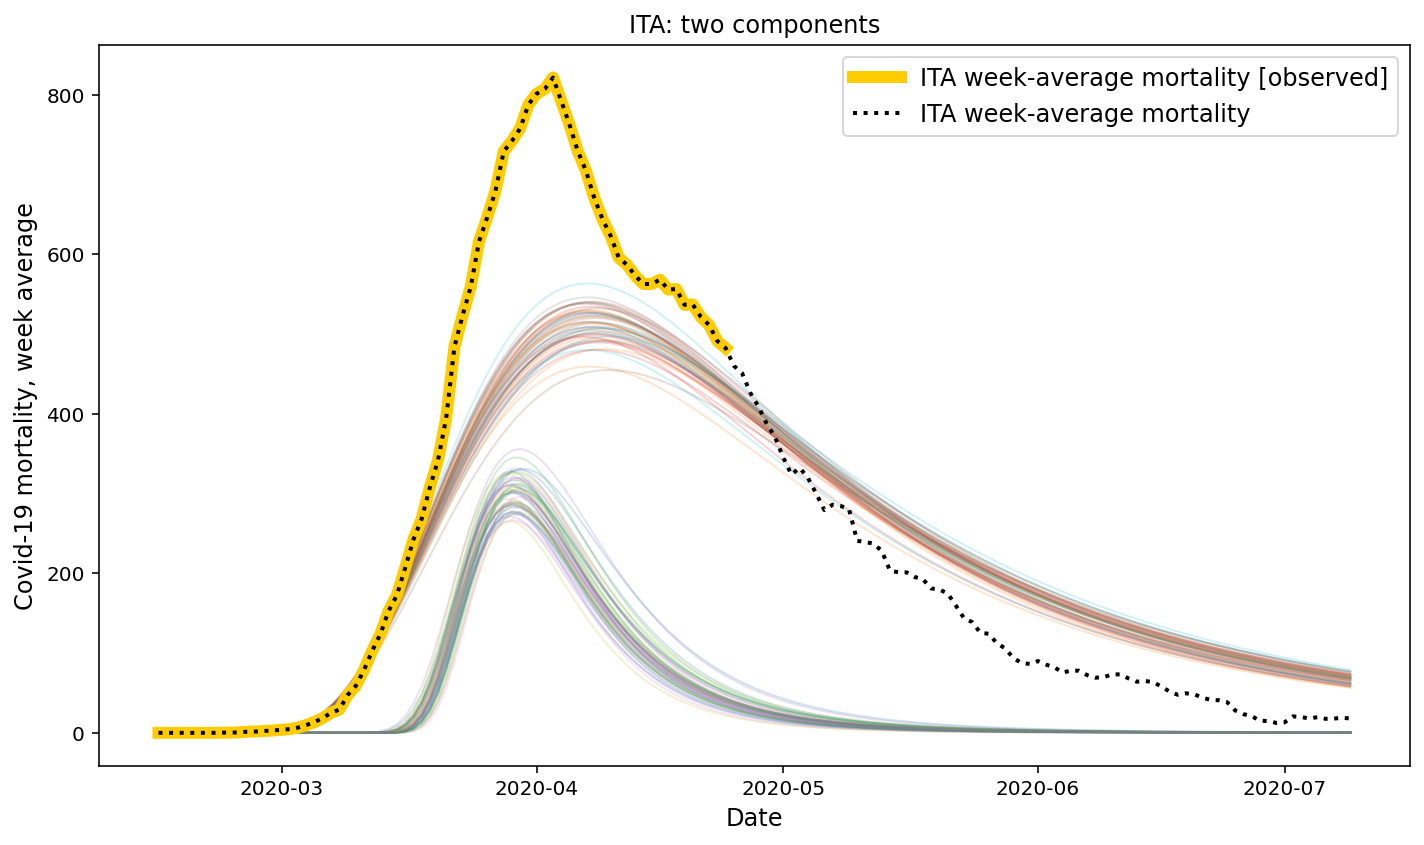

In [193]:
#@title Plotting separate components
save_figure = False

# ---------- Plotting ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lw = 1

y_all_ = y_all[shift:]
x_all_ = np.arange(len(y_all_))

x_shortened = x_all[x_all >= min_date]

# for i, p in enumerate(mixture_params_max):
#   yhat = frechet(p, x_all_)
#   yhat = np.concatenate([np.zeros(shift), yhat])
#   ax.plot(x_all, yhat, '-', lw=1, label='Frechet component ' + str(i))

for params in mixture_param_list:
  for p in params:
    yhat = frechet(p, x_all_, features_all_)
    yhat = np.concatenate([np.zeros(shift), yhat])
    ax.plot(x_shortened, yhat[-len(x_shortened):], '-', alpha=0.2, lw=1)
  
ax.plot(x[x >= min_date], y[-sum(x >= min_date):],
        color=(255 / 255.0, 204 / 255.0, 0 / 255.0),
        lw=6, alpha=1.0, label=ISO + ' week-average mortality [observed]')
ax.plot(x_shortened,
        y_all[-len(x_shortened):],
        ':k', lw=2, label=ISO + ' week-average mortality')

ax.legend(loc='upper right', ncol=1, fontsize=12)
ax.set_title(ISO + ': two components', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Covid-19 mortality, week average', fontsize=12)
plt.tight_layout()
if save_figure:
  plt.savefig(ISO + '-two-components.pdf')
  files.download(ISO + '-two-components.pdf') 
else:
  plt.show()

yhat = yhat_total / len(mixture_param_list)